In [1]:
import pandas as pd
import numpy as np

from xgboost import XGBClassifier

import shap
shap.initjs()

In [2]:
data = pd.read_csv('love_data_merged.csv')
data.head()

,destination_country,regional_airport_group,party_type,duration,created_time_of_day,enquiry_dow,departure_dow,departure_month,stars,board_basis,provider,haul,type
0,Anywhere,London All,Couple,11-13,Night,Sat,Thu,Jun,3,Room Only,Holiday Genie WorldWide,Long,Beach
1,Anywhere,London All,Couple,11-13,Night,Sat,Thu,Jun,3,Room Only,Holiday Genie WorldWide,Long,Beach
2,Anywhere,London All,Couple,11-13,Night,Sat,Thu,Jun,3,Room Only,Holiday Genie WorldWide,Long,Beach
3,Anywhere,London All,Couple,11-13,Night,Sat,Thu,Jun,3,Room Only,Holiday Genie WorldWide,Long,Beach
4,Anywhere,London All,Couple,11-13,Night,Sat,Thu,Jun,3,Room Only,Holiday Genie WorldWide,Long,Beach


In [3]:
def generate_label(df, provider):
    df['label'] = np.where(df['provider']==provider, 1, 0)
    return df.drop('provider', axis=1)
data = generate_label(data, 'Love Holidays')
data.head()

,destination_country,regional_airport_group,party_type,duration,created_time_of_day,enquiry_dow,departure_dow,departure_month,stars,board_basis,haul,type,label
0,Anywhere,London All,Couple,11-13,Night,Sat,Thu,Jun,3,Room Only,Long,Beach,0
1,Anywhere,London All,Couple,11-13,Night,Sat,Thu,Jun,3,Room Only,Long,Beach,0
2,Anywhere,London All,Couple,11-13,Night,Sat,Thu,Jun,3,Room Only,Long,Beach,0
3,Anywhere,London All,Couple,11-13,Night,Sat,Thu,Jun,3,Room Only,Long,Beach,0
4,Anywhere,London All,Couple,11-13,Night,Sat,Thu,Jun,3,Room Only,Long,Beach,0


In [4]:
cat_cols = data.select_dtypes('object').columns
data[cat_cols] = data[cat_cols].astype('category')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1976459 entries, 0 to 1976458
Data columns (total 13 columns):
destination_country       category
regional_airport_group    category
party_type                category
duration                  category
created_time_of_day       category
enquiry_dow               category
departure_dow             category
departure_month           category
stars                     int64
board_basis               category
haul                      category
type                      category
label                     int64
dtypes: category(11), int64(2)
memory usage: 50.9 MB


In [5]:
cat_cols = data.select_dtypes(['category']).columns
data[cat_cols] = data[cat_cols].apply(lambda x: x.cat.codes)
data.head()

,destination_country,regional_airport_group,party_type,duration,created_time_of_day,enquiry_dow,departure_dow,departure_month,stars,board_basis,haul,type,label
0,1,0,0,1,2,1,4,6,3,5,1,1,0
1,1,0,0,1,2,1,4,6,3,5,1,1,0
2,1,0,0,1,2,1,4,6,3,5,1,1,0
3,1,0,0,1,2,1,4,6,3,5,1,1,0
4,1,0,0,1,2,1,4,6,3,5,1,1,0


In [6]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(data, test_size=0.3, random_state=42)
X_train = train_set.drop(columns=['label'])
y_train = train_set['label'].copy()
X_test = test_set.drop(columns=['label'])
y_test = test_set['label'].copy()
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1383521, 12) (1383521,)
(592938, 12) (592938,)


### Keep another copy of the training data without encoding

In [7]:
data_disp = pd.read_csv('love_data_merged.csv')
data_disp = generate_label(data_disp, 'Love Holidays')

train_set_disp, test_set_disp = train_test_split(data_disp, test_size=0.3, random_state=42)
X_train_disp = train_set_disp.drop(columns=['label'])
y_train_disp = train_set_disp['label'].copy()
X_test_disp = test_set_disp.drop(columns=['label'])
y_test_disp = test_set_disp['label'].copy()
print(X_train_disp.shape, y_train_disp.shape)
print(X_test_disp.shape, y_test_disp.shape)
data_disp.head()

(1383521, 12) (1383521,)
(592938, 12) (592938,)


,destination_country,regional_airport_group,party_type,duration,created_time_of_day,enquiry_dow,departure_dow,departure_month,stars,board_basis,haul,type,label
0,Anywhere,London All,Couple,11-13,Night,Sat,Thu,Jun,3,Room Only,Long,Beach,0
1,Anywhere,London All,Couple,11-13,Night,Sat,Thu,Jun,3,Room Only,Long,Beach,0
2,Anywhere,London All,Couple,11-13,Night,Sat,Thu,Jun,3,Room Only,Long,Beach,0
3,Anywhere,London All,Couple,11-13,Night,Sat,Thu,Jun,3,Room Only,Long,Beach,0
4,Anywhere,London All,Couple,11-13,Night,Sat,Thu,Jun,3,Room Only,Long,Beach,0


### Training

In [8]:
model = XGBClassifier(
        objective='binary:logistic',
        booster='gbtree',
        random_state=42,
        learning_rate=1,
        n_estimators=150,
        max_depth=5,
        gamma=0.05)
model.fit(X_train, y_train)
model

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0.05, learning_rate=1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=150,
       n_jobs=1, nthread=None, objective='binary:logistic',
       random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)

### Test Prediction

In [9]:
predictions = model.predict(X_test[:10])
predictions

array([0, 0, 0, 1, 0, 0, 1, 1, 0, 0])

### Evaluation

In [10]:
from sklearn.metrics import roc_auc_score
y_pred = model.predict_proba(X_test)[:, 1]
roc_auc_score(y_test, y_pred)

0.8269239913138882

### SHAP time!

In [13]:
import time
start = time.time()

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test[:10000])

end = time.time()
print(end - start)

pd.DataFrame(shap_values).head()

8.038162469863892


,0,1,2,3,4,5,6,7,8,9,10,11
0,0.072317,-0.173798,0.016934,-0.037018,-0.062021,-0.013622,-0.066584,-0.484215,-0.018000,-0.522413,0.349707,0.138608
1,-1.718223,-0.225250,0.254573,-0.066577,-0.043433,-0.090752,-0.015386,0.275418,0.247731,-1.214120,-1.829365,0.022861
2,-0.412590,0.033973,0.085428,-0.004306,-0.022032,0.056399,-0.022845,-0.070515,-0.236231,0.086189,0.393337,0.143541
3,1.381804,-0.079512,-0.141709,0.109181,-0.040940,-0.143421,-0.135914,0.014441,-0.120224,0.974802,0.439364,-1.088616
4,-0.033339,-0.039185,-0.133626,0.064982,-0.008364,0.004341,-0.233199,0.104170,-0.282162,0.205422,0.333547,0.138301


In [14]:
# note this is log odds, not probability
print('Expected Value:', explainer.expected_value)

Expected Value: -0.8769393


In [15]:
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test_disp.iloc[0,:])

In [16]:
shap.force_plot(explainer.expected_value, shap_values[3,:], X_test_disp.iloc[3,:])

In [18]:
shap.force_plot(explainer.expected_value, shap_values[:500,:], X_test_disp.iloc[:500,:])

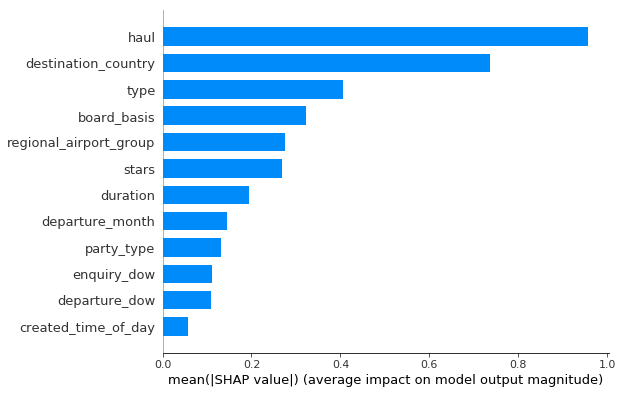

In [19]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

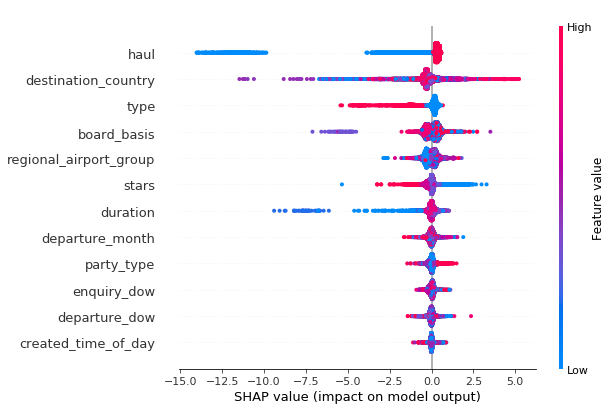

In [21]:
shap.summary_plot(shap_values, X_test[:10000])

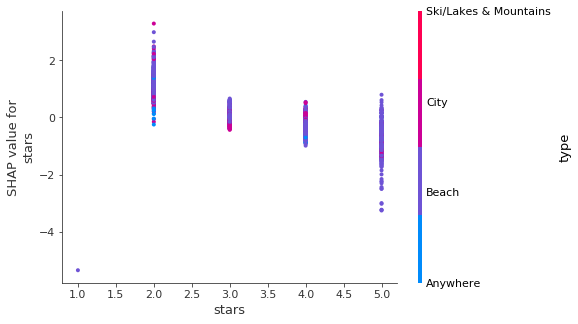

In [38]:
shap.dependence_plot(ind='stars', interaction_index="type",
                     shap_values=shap_values, 
                     features=X_test[:10000], display_features=X_test_disp)